We want to understand several things:

1. Can descriptions be a viable alternative to outlines?
2. Do descriptions change year over year?
3. Can logistic regression generalize to descriptions when trained on outlines?

If no to #1, then we should not move forward with descriptions and #2 and #3 do not matter.

If yes to #1, but no to #2, then we must identify courses with change descriptions each year and tag them.

If yes to #1 and #2, but no to #3, then that tagging initiative should be done manually (or with some secondary validation after model prediction)

In [143]:
import pandas as pd
import re
from glob import glob
from rapidfuzz import fuzz
import sys
sys.path.append("../../scripts")
from variables import SDG_MAP, ALL_EVAL_RESULTS_PATH

import matplotlib.pyplot as plt
import seaborn as sns
import math
SDG_ORDER = SDG_MAP.keys()

In [98]:
def count_sdgs(data, label_col='labels'):
    sdg_counts = {k: 0 for k in SDG_MAP.keys()}
    total_rows = data.shape[0]
    courses_with_sdgs = 0
    for label_data in data[label_col]:
        if len(label_data) > 0:
            courses_with_sdgs += 1
        for label in set(label_data):
            sdg_counts[label] += 1

    return sdg_counts, total_rows, courses_with_sdgs

def create_sdg_df(sdg_counts, total_rows, courses_with_sdgs, project_name, datatype):
    all_results = []

    for sdg, sdg_count in sdg_counts.items():
        all_results.append(
            dict(
                project_name=project_name,
                sdg=sdg,
                datatype=datatype,
                total_rows=total_rows,
                courses_with_sdgs=courses_with_sdgs,
                positive=sdg_count,
                negative=total_rows - sdg_count
            )
        )

    return pd.DataFrame(all_results)

def calculate_cm(merged, label_col_left, label_col_right):
    cm = {sdg:{"both":0, label_col_left:0, label_col_right:0, "neither":0, "SDG":sdg} for sdg in SDG_ORDER}
    for i, row in merged.iterrows():
        ref_labels = row[label_col_left]
        pred_labels = row[label_col_right]

        for sdg in SDG_ORDER:
            if sdg in ref_labels and sdg in pred_labels:
                cm[sdg]["both"] += 1
            elif sdg in ref_labels and sdg not in pred_labels:
                cm[sdg][label_col_left] += 1
            elif sdg not in ref_labels and sdg in pred_labels:
                cm[sdg][label_col_right] += 1
            else:
                cm[sdg]["neither"] += 1

    return pd.DataFrame(cm.values())

# Compare manual outline vs manual desc (GRAD)

This gives us an understanding of if we can reliably use descriptions as an alternative to outlines for SDG tagging.

In [124]:
# Load 2023 manual data on outlines and descriptions
manual_desc = pd.read_json("../../data/raw/2023_grad_desc.jsonl", orient="records", lines=True)
manual_outline = pd.read_json("../../data/raw/2023_grad_outlines.jsonl", orient="records", lines=True)

merged = pd.merge(manual_desc, manual_outline, how='inner', on=['CRSE_ID'], suffixes=("__desc", "__outline"))
man_desc_counts = create_sdg_df(*count_sdgs(merged, "labels__desc"), "2023_grad_desc", "raw")
man_outline_counts = create_sdg_df(*count_sdgs(merged, "labels__outline"), "2023_grad_outlines", "raw")

Total Proportion


C:\Users\arman\AppData\Local\Temp\ipykernel_24892\2902175044.py:22: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


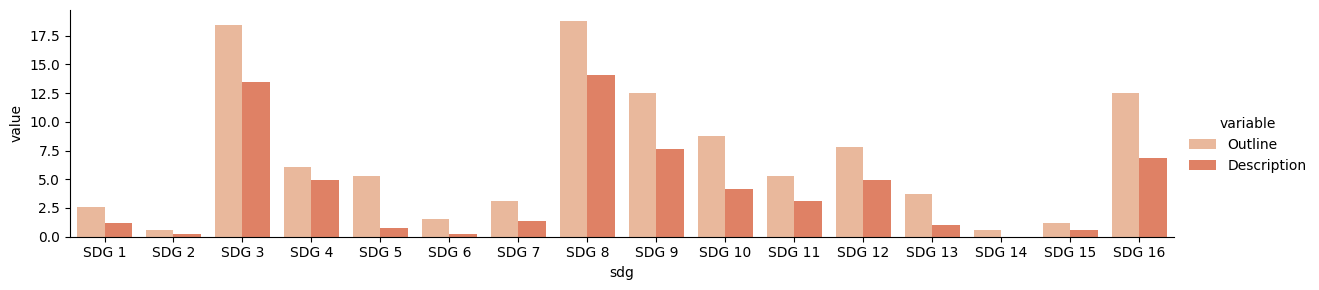

SDG Proportion


C:\Users\arman\AppData\Local\Temp\ipykernel_24892\2902175044.py:36: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


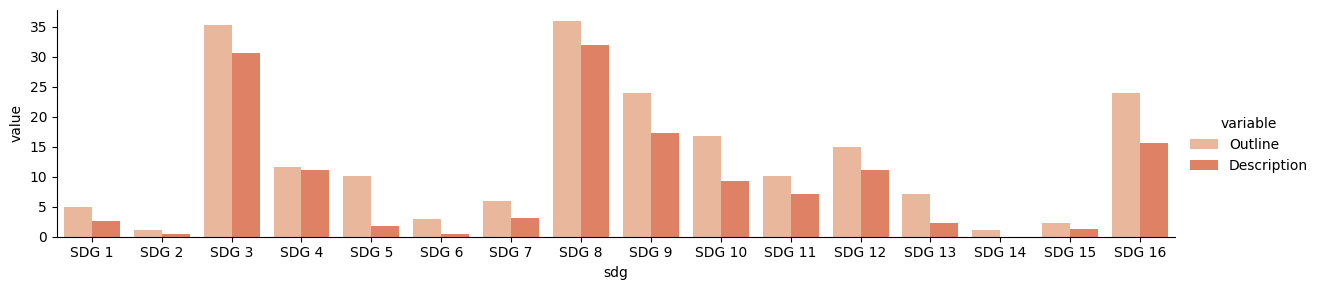

In [125]:
mapping = {
    "Outline Total Proportion": "Outline",
    "Outline SDG Proportion": "Outline",
    "Desc Total Proportion": "Description",
    "Desc SDG Proportion": "Description",
}

group = man_desc_counts.merge(man_outline_counts, on="sdg", suffixes=("__desc", "__outline"))
group["Desc Total Proportion"] =  group["positive__desc"] / group["total_rows__desc"] * 100
group["Outline Total Proportion"] =  group["positive__outline"] / group["total_rows__outline"] * 100
group["Desc SDG Proportion"] =  group["positive__desc"] / group["courses_with_sdgs__desc"] * 100
group["Outline SDG Proportion"] =  group["positive__outline"] / group["courses_with_sdgs__outline"] * 100

total_melt = group.melt(id_vars=["sdg"], value_vars=["Outline Total Proportion", "Desc Total Proportion"]).map(
    lambda x: mapping.get(x, x)
)
sdg_relative_melt = group.melt(id_vars=["sdg"], value_vars=["Outline SDG Proportion", "Desc SDG Proportion"]).map(
    lambda x: mapping.get(x, x)
)

print("Total Proportion")
g = sns.catplot(
    data=total_melt,
    y="value",
    x="sdg",
    hue="variable",
    kind="bar",
    height=3,
    aspect=4,
    order=SDG_MAP.keys(),
    palette=sns.color_palette("rocket_r"),
)
plt.show()

print("SDG Proportion")
g = sns.catplot(
    data=sdg_relative_melt,
    y="value",
    x="sdg",
    hue="variable",
    kind="bar",
    height=3,
    aspect=4,
    order=SDG_MAP.keys(),
    palette=sns.color_palette("rocket_r"),
)
plt.show()

In [155]:
sdg_relative_pivot = sdg_relative_melt.pivot(index="sdg", columns=['variable'])
print("Difference calculation:")
print("Mean:", (sdg_relative_pivot[("value", "Outline")] - sdg_relative_pivot[("value", "Description")]).mean())
print("Median:", (sdg_relative_pivot[("value", "Outline")] - sdg_relative_pivot[("value", "Description")]).median())

Difference calculation:
Mean: 3.8760923845193513
Median: 3.4357053682896384


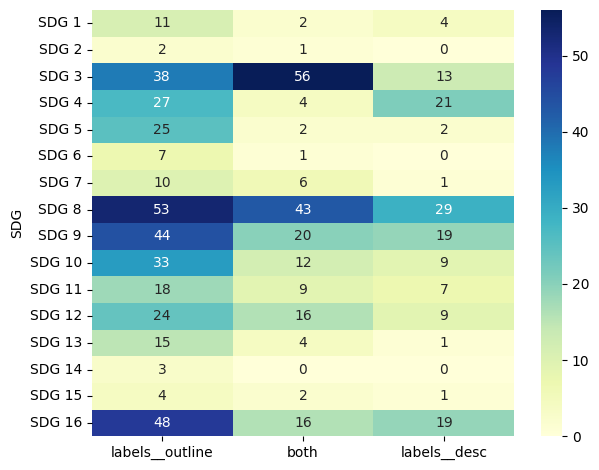

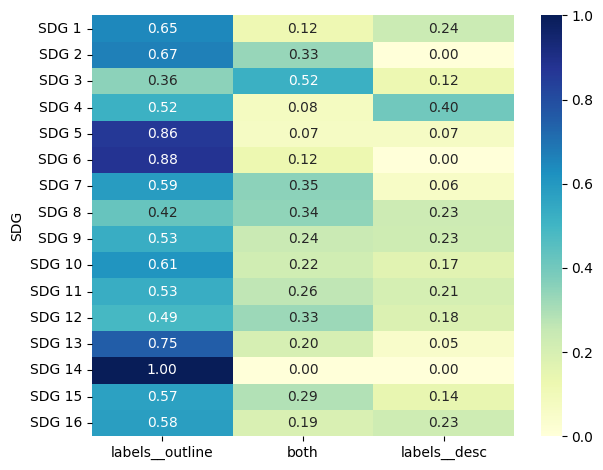

In [105]:
left_col = "labels__outline"
right_col = "labels__desc"
cm = calculate_cm(merged, left_col, right_col)

cm_prepped = cm[["SDG", left_col, "both", right_col]].set_index("SDG").reindex(SDG_ORDER)
sns.heatmap(cm_prepped, cmap="YlGnBu", annot=True)
plt.tight_layout()
plt.show()

cm["courses_w_sdg"] = cm[left_col] + cm["both"] + cm[right_col]
cm[left_col] = cm[left_col] / cm["courses_w_sdg"]
cm["both"] = cm["both"] / cm["courses_w_sdg"]
cm[right_col] = cm[right_col] / cm["courses_w_sdg"]


cm_prepped = cm[["SDG", left_col, "both", right_col]].set_index("SDG").reindex(SDG_ORDER)
sns.heatmap(cm_prepped, cmap="YlGnBu", annot=True, fmt=".2f")
plt.tight_layout()
plt.show()

# Compare desc YOY

This gives an understanding of how much descriptions change year over year.

In [31]:
ugrad_desc_2023 = pd.read_json("../../data/raw/2023_ugrad_desc.jsonl", orient="records", lines=True)
ugrad_desc_2024 = pd.read_json("../../data/raw/2024_ugrad_desc.jsonl", orient="records", lines=True)    

def bin_similarity(similarity):
    if similarity >= 95:
        return "0. 95-100"
    elif similarity >= 90:
        return "1. 90-94"
    elif similarity >= 85:
        return "2. 85-89"
    elif similarity >= 80:
        return "3. 80-84"
    else:
        return "4. < 80"

yoy_merged = pd.merge(ugrad_desc_2023, ugrad_desc_2024, how='inner', on=['id'], suffixes=("__2023", "__2024"))
yoy_merged["similarity"] = yoy_merged.apply(lambda row: fuzz.ratio(row["text__2023"], row["text__2024"]), axis=1)
yoy_merged["binned_sim"] = yoy_merged["similarity"].apply(bin_similarity)
yoy_merged["exact_match"] = yoy_merged.apply(lambda row: row["text__2023"] == row["text__2024"], axis=1)

In [32]:
pd.concat([yoy_merged.value_counts("exact_match"), yoy_merged.value_counts("exact_match", normalize=True)*100], axis=1)

,count,proportion
exact_match,,
True,2402,79.483786
False,620,20.516214


In [39]:
pd.concat([yoy_merged["binned_sim"].value_counts(), round(yoy_merged["binned_sim"].value_counts(normalize=True)*100, 1)], axis=1).sort_index()

,count,proportion
binned_sim,,
0. 95-100,2813,93.1
1. 90-94,87,2.9
2. 85-89,49,1.6
3. 80-84,27,0.9
4. < 80,46,1.5


# Compare manual desc vs LR desc (GRAD)

This gives us an understanding of how well logistic regression performs on descriptions.

In [39]:
manual_desc = pd.read_json("../../data/raw/2023_grad_desc.jsonl", orient="records", lines=True)
lr_desc_paths = glob("../../data/predictions/SDG*-logistic_regression-2023_grad_desc-raw__predictions.jsonl")

man_courses_w_sdgs = manual_desc[manual_desc["labels"].apply(len) > 0].shape[0]
lr_courses_w_sdgs = set()

for path in lr_desc_paths:
    temp_df = pd.read_json(path, orient="records", lines=True)
    lr_courses_w_sdgs |= set(temp_df[temp_df["prediction"].apply(lambda d: d["prediction"] == 1)]["index"])

lr_courses_w_sdgs = len(lr_courses_w_sdgs)

In [19]:
all_results = []

sdg_counts, total_rows, courses_with_sdgs = count_sdgs(manual_desc)
for sdg, sdg_count in sdg_counts.items():
    all_results.append(
        dict(
            project_name="2023_grad_desc",
            sdg=sdg,
            datatype="raw",
            total_rows=total_rows,
            courses_with_sdgs=courses_with_sdgs,
            positive=sdg_count,
            negative=total_rows - sdg_count,
            pos_perc=sdg_count / total_rows,
            neg_perc=(total_rows - sdg_count) / total_rows,
        )
    )

data_counts_df = pd.DataFrame(all_results)

model_performance = pd.read_json(ALL_EVAL_RESULTS_PATH, orient="records", lines=True)
merged = data_counts_df.merge(
    model_performance, how="inner", on=["sdg", "project_name", "datatype"]
)
group = merged[merged["model_name"] == 'logistic_regression']

C:\Users\arman\AppData\Local\Temp\ipykernel_24892\3711854429.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["specificity"] = group["TN"]/ (group["TN"] + group["FP"])


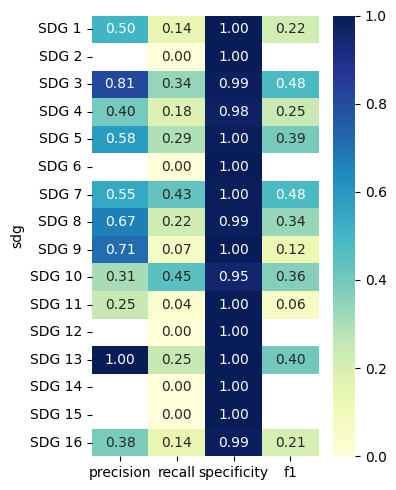

In [20]:
group["specificity"] = group["TN"]/ (group["TN"] + group["FP"])
prf1 = group[["sdg", 'precision', 'recall', 'specificity', 'f1']].set_index("sdg").reindex(SDG_ORDER)
plt.figure(figsize=(4,5))
sns.heatmap(prf1, cmap='YlGnBu', annot=True, fmt='.2f')
plt.tight_layout()
plt.show()

In [46]:
group["Manual Total Proportion"] = group.apply(lambda row: round(row["positive"] / row["total_rows"] * 100, 2), axis=1)
group["LR Total Proportion"] = group.apply(lambda row: round((row["TP"] + row["FP"]) / row["total_rows"] * 100, 2), axis=1)

group["Manual SDG Proportion"] = group.apply(lambda row: round(row["positive"] / man_courses_w_sdgs * 100, 2), axis=1)
group["LR SDG Proportion"] = group.apply(lambda row: round((row["TP"] + row["FP"]) / lr_courses_w_sdgs * 100, 2), axis=1)

C:\Users\arman\AppData\Local\Temp\ipykernel_24892\1041279425.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["Manual Total Proportion"] = group.apply(lambda row: round(row["positive"] / row["total_rows"] * 100, 2), axis=1)
C:\Users\arman\AppData\Local\Temp\ipykernel_24892\1041279425.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group["LR Total Proportion"] = group.apply(lambda row: round((row["TP"] + row["FP"]) / row["total_rows"] * 100, 2), axis=1)
C:\Users\arman\AppData\Local\Temp\ipykerne

Total Proportion


C:\Users\arman\AppData\Local\Temp\ipykernel_24892\3151745637.py:17: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


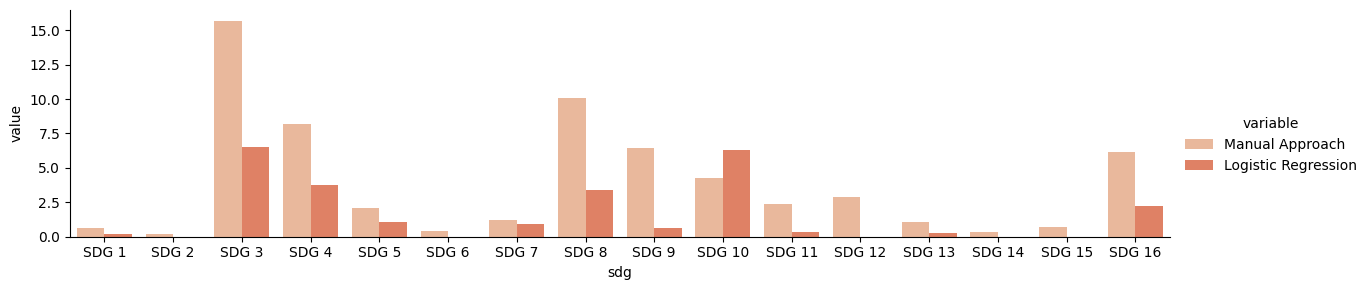

SDG Proportion


C:\Users\arman\AppData\Local\Temp\ipykernel_24892\3151745637.py:31: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  g = sns.catplot(


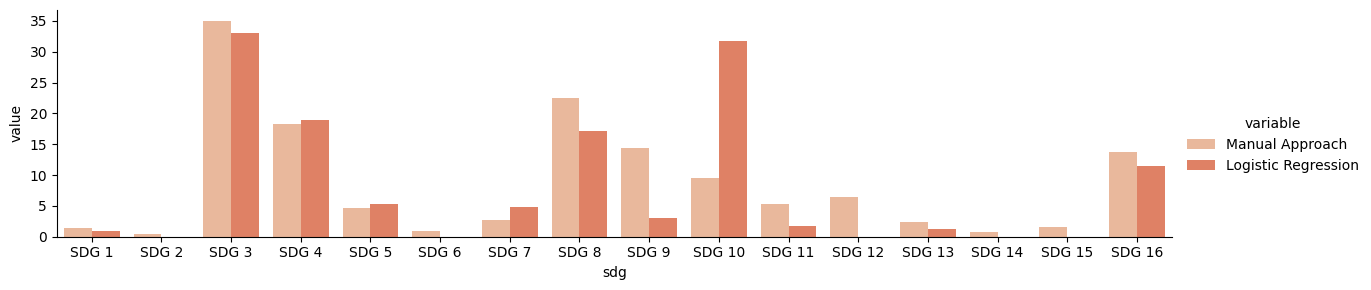

In [51]:
mapping = {
    "positive": "Manual approach",
    "Manual Total Proportion": "Manual Approach",
    "Manual SDG Proportion": "Manual Approach",
    "TP": "Logistic Regression",
    "LR Total Proportion": "Logistic Regression",
    "LR SDG Proportion": "Logistic Regression",
}
total_melt = group.melt(id_vars=["sdg"], value_vars=["Manual Total Proportion", "LR Total Proportion"]).map(
    lambda x: mapping.get(x, x)
)
sdg_relative_melt = group.melt(id_vars=["sdg"], value_vars=["Manual SDG Proportion", "LR SDG Proportion"]).map(
    lambda x: mapping.get(x, x)
)

print("Total Proportion")
g = sns.catplot(
    data=total_melt,
    y="value",
    x="sdg",
    hue="variable",
    kind="bar",
    height=3,
    aspect=4,
    order=SDG_MAP.keys(),
    palette=sns.color_palette("rocket_r"),
)
plt.show()

print("SDG Proportion")
g = sns.catplot(
    data=sdg_relative_melt,
    y="value",
    x="sdg",
    hue="variable",
    kind="bar",
    height=3,
    aspect=4,
    order=SDG_MAP.keys(),
    palette=sns.color_palette("rocket_r"),
)
plt.show()